In [1]:
# Boilerplate
%matplotlib inline

# Intel DAAL related imports
from daal.data_management import HomogenNumericTable

# Helpersfor getArrayFromNT and printNT. See utils.py
from utils import *

# Import numpy, matplotlib, seaborn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Plotting configurations
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (12, 9)

# Handwritten Digits Recognition with SVM

This lab is partially based on a [scikit-learn tutorial](http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html) on the same subject.

### Tutorial brief
This lab studies a popular and powerful classification algorithm, _Support Vector Machine_ (SVM). We build a multi-class classifier on top of SVM using pyDAAL, and use it to tackle a famous classification problem in machine learning: handwritten digits recognition. We go on to solve the same problem using scikit-learn's Support Vector Classifier, and compare performance and classification accuracy between the pyDAAL solution and the scikit-learn solution.

The lab code contains definition of a `MultiClassSVM` class, which consists of a `train` method and a `predict` method, among other helper functions. Except for the `predit` method, all parts of the class is implemented. In the exercise, you are asked to implement the `predict` method.

### Learning objectives
* To understand and practice the typical code sequence of using pyDAAL for classification.
* To see pyDAAL's performance advantage over scikit-learn.

### SVM introduction
SVM belongs to a family of generalized linear classification problems. It is a binary (two-class) classifier. It is typically used a key ingredient of a multi-class classifier to address multi-class classification problems.

According to Wikipedia [link](https://en.wikipedia.org/wiki/Support_vector_machine):

> An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall on.

Despite its origin as a linear classifier, SVM is often used for non-linear classification problems. The key is the _kernel functions_. A kernel function maps features to higher dimensional feature spaces, making SVM to be able to capture non-linear relations. The SVM in DAAL supports two kernel functions: linear and KBF (Gausian kernel).

### Multi-class classifier introduction
SVM by itself is a binary (two-class) classifier. To use it on multi-class problems, DAAL employs a technique called One-Against-One. In plain language, let $K$ be the number of classes, the One-Against-One approach solves a two-class problem for each possible pair of labels of the $K$ labels. Then, the predicted label is the one that was predicted by the majority of the two-class classifiers.

### The handwritten digits dataset

Scikit-learn has some functions to load popular datasets for eager learners. These datasets are available through [sklearn.datasets](http://scikit-learn.org/stable/datasets). The [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits) method loads and returns the digits dataset. Because the dataset internally uses NumPy ndarray to store information, we can convert it to DAAL `NumericTables`, and pass them to DAAL algorithms. 

After loading the data, we take a quick look at the sizes and dimensions. There are 1797 samples (i.e. images of handwritten digits) in the dataset, and each sample has 64 features. Note that the images are stored in `digits.data` and the corresponding labels are stored in `digits.target`.

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()
print(digits.data.shape)
print(digits.target.shape)

(1797, 64)
(1797,)


We can visualize the first 10 images and their correct labels (ground truth). The code below is directly copied from the scikit-learn tutorial:

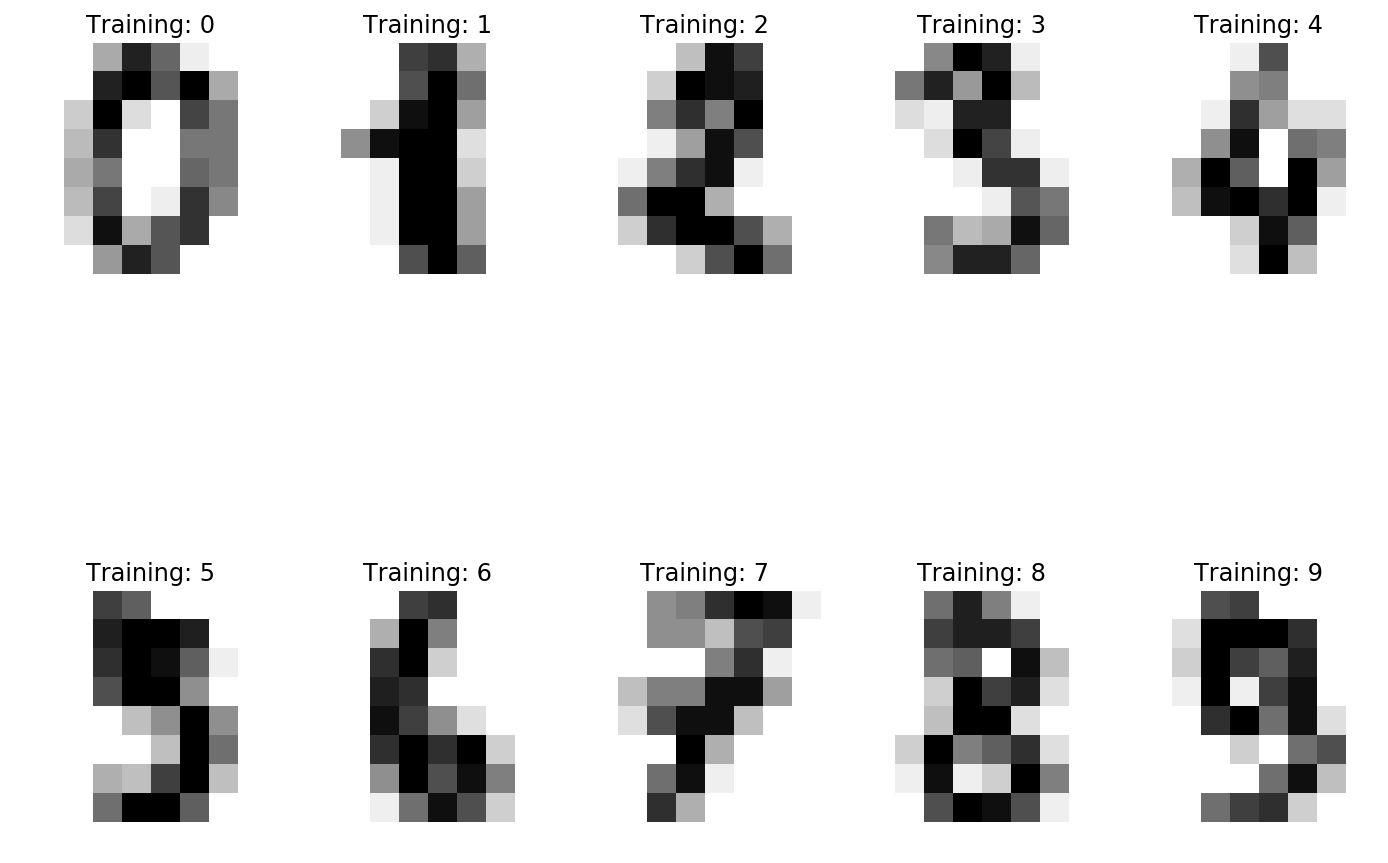

In [3]:
images_and_labels = list(zip(digits.images[:10], digits.target[:10]))
for index, (image, label) in enumerate(images_and_labels):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

### Data preparation
We save the last 100 samples from the dataset for testing, and use the rest to train a classifier.

As described above, images and the corresponding labels are accessible in `digits.data` and `digits.target`, respectively. The code below creates four Intel DAAL numeric tables, for `training_data`, `training_labels`, `test_data`, and `test_labels`.

It is important to keep in mind that DAAL NumericTables can only be created from ndarrays with C-contiguous memory layout. `digits.data` and `digits.target` are not C-contiguous. You can check this with:

```python
digits.data.flags['C']
```
To put them into correct memory layout, we use NumPy function [`np.ascontiguousarray`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ascontiguousarray.html).

In [4]:
# Split the data into training data and labels, and create numeric tables
nsamples = len(digits.images)
data = np.ascontiguousarray(digits.data, dtype = np.double)
labels = np.ascontiguousarray(digits.target.reshape(nsamples,1), dtype = np.double)

training_data = HomogenNumericTable(data[:-100])
training_labels = HomogenNumericTable(labels[:-100])

test_data = HomogenNumericTable(data[-100:])
test_labels = HomogenNumericTable(labels[-100:])

### Create a multi-class classifier based on SVM

The definition of the `MulticlassSVM` class using pyDAAL is below. A few things to help understanding the code:

1. The implementation uses `multi_class_classifier` from pyDAAL, which can be parameterized by an underlying two-class classifier, and the number of classes. SVM is hard-coded as the two-class classifier, while the number of classes is a user input.
2. The SVM classifier itself takes several parameters, in particular,
    * Kernel function: Either a linear kernel or an RBF kernel. A kernel function also has its own parameters. For example, the RBF kernel is parameterized by $\sigma$.
    * Cache size (in bytes): A cache is used to store the kernel matrix. For best performance, the cache size should be about `number_of_samples x number_of_samples x sizeof(feature_data_type)`.
    * C: Upper bound in conditions of the quadratic optimization problem. It is used to control the trade-off between variance and bias of the model. It is typically set to 1.0.
    * shrinking: A bool value that enables or disables kernel shrinking. Kernel shrinking is an optimization technique to reduce the amount of kernel computation.
    * There are other parameters, such as accuracy threshold and $\tau$ the parameter for the WSS scheme, that are not explicitly set in the code below. We just use their default values. For details about what these parameters are about, refer to the [Intel DAAL Developer Guide](https://software.intel.com/sites/products/documentation/doclib/daal/daal-user-and-reference-guides/index.htm).
3. The `predict` method of the class is left as an exercise. You should follow the `train` method as an example to flesh out the implementation for `predict`.


In [5]:
from daal.algorithms.svm import training as svm_training
from daal.algorithms.svm import prediction as svm_prediction
from daal.algorithms.kernel_function import linear, rbf
from daal.algorithms.multi_class_classifier import training as multiclass_training
from daal.algorithms.multi_class_classifier import prediction as multiclass_prediction
from daal.algorithms.classifier import training as training_params
from daal.algorithms.classifier import prediction as prediction_params

class MulticlassSVM:


    def __init__(self, nclasses):
        """Initialize class parameters

        Args:
           nclasses: number of classes
        """

        self._nclasses = nclasses
        # Create an SVM two-class classifier object for training
        self._svm_training_alg = svm_training.Batch_Float64DefaultDense()
        # Create an SVM two-class classifier object for prediction
        self._svm_prediction_alg = svm_prediction.Batch_Float64DefaultDense()

    
    def setSVMParams(self, 
            cachesize = 1000000000, 
            C = 1.0,
            sigma = 1.0,
            kernel = linear.Batch_Float64DefaultDense(),
            shrinking = False):
        """Tweak SVM training and prediction algorithm parameters

        Args:
            cachesize: size of chache in bytes for storing kernel matrix
            kernel: SVM kernel, can be either linear or rbf
            sigma: Coefficient of the rbf kernel
            shrinking: whether do shrinking optimization or not
        """

        self._svm_training_alg.parameter.cacheSize = cachesize 
        self._svm_training_alg.parameter.C = C 
        if getattr(kernel.parameter, 'sigma', None):
            kernel.parameter.sigma = sigma
        self._svm_training_alg.parameter.kernel = kernel
        self._svm_prediction_alg.parameter.kernel = kernel
        self._svm_training_alg.parameter.doShrinking = shrinking



    def train(self, data, labels):
        """Train an SVM model.

        Args:
            data: training data
            labels: ground truth known for training data 

        Returns:
            An SVM model object
        """
        
        # Create a multiclass classifier object based on the
        # SVM two-class classifier
        multiclass_training_alg = multiclass_training.Batch_Float64OneAgainstOne()
        multiclass_training_alg.parameter.nClasses = self._nclasses
        multiclass_training_alg.parameter.training = self._svm_training_alg
        multiclass_training_alg.parameter.prediction = self._svm_prediction_alg

        # Pass training data and labels
        multiclass_training_alg.input.set(training_params.data, data)
        multiclass_training_alg.input.set(training_params.labels, labels)

        # Build the model and return it
        return multiclass_training_alg.compute().get(training_params.model)

    

    def predict(self, model, testdata):
        """Make predictions for unseen data using a learned model.

        Args:
            model: a learned SVM model
            testdata: new data

        Returns:
            A NumericTable containing predicted labels
        """

        # Create a multiclass classifier object based on the
        # SVM two-class classifier
        #
        # YOUR CODE HERE
        #
        # The multi-class prediction algorithm you need is Batch_Float64DefaultDenseOneAgainstOne
        # Follow the example in the `train` method to set parameters, including nClasses, and training 
        # and prediction algorithms for the underlying two-class classifier. 
        
        
        # Pass a model and input data
        #
        # YOUR CODE HERE
        #
        # Use the input.setModel method to specify a pre-trained model. The input ID to use is
        # prediction_params.model.
        # Use the input.setTable method to specify test data. The input ID to use is prediction_params.data
       

        # Compute and return prediction results
        #
        # YOUR CODE HERE
        #
        # Call the `compute` method of the multi-class prediction algorithm. Store the return value into 
        # variable `results`.
     
        return results.get(prediction_params.prediction)

Now the `MulticlassSVM` is fully implemented, we can apply it to the handwritten digits recognition problem.

The code below creates a `MulticlassSVM` object, sets some parameters, and then continues to train a model using the training data and training labels we defined above. Next, the model is used to make predictions on the test data. We can time the training and prediction stages, respectively. We will compare the timings with that of the scikit-learn SVC solution later on. 

In [6]:
#from svm_multi_class import *

nclasses = 10
classifier = MulticlassSVM(nclasses)

classifier.setSVMParams(
        cachesize = 32000000,
        kernel = linear.Batch_Float64DefaultDense(),
        shrinking = True)

%time svm_model = classifier.train(training_data, training_labels)

%time predictions = classifier.predict(svm_model, test_data)

Wall time: 32 ms
Wall time: 8.01 ms


### Quality metrics
We can check the performance of the model by computing quality metrics. Some DAAL algorithms, including the multi-class classifier, allow users to compute and query quality metrics. There are many aspects in a multi-class classifier's quality metrics, but "average accuracy" is probably the most commonly used inidcator. For convenience, we define a class `ClassifierQualityMetrics` in file [quality_metrics.py](quality_metrics.py) for you to easily access classification quality metrics. 

In [7]:
from quality_metrics import *

quality = ClassifierQualityMetrics(test_labels, predictions, nclasses)
print('Average accuracy: {:.2f}%'.format(quality.get('accuracy')*100))

Average accuracy: 99.40%


### Visualize predictions
The code below shows the last 10 images we did predictions for, together with the predicted labels. Does our classifier do a good job in guessing the labels?

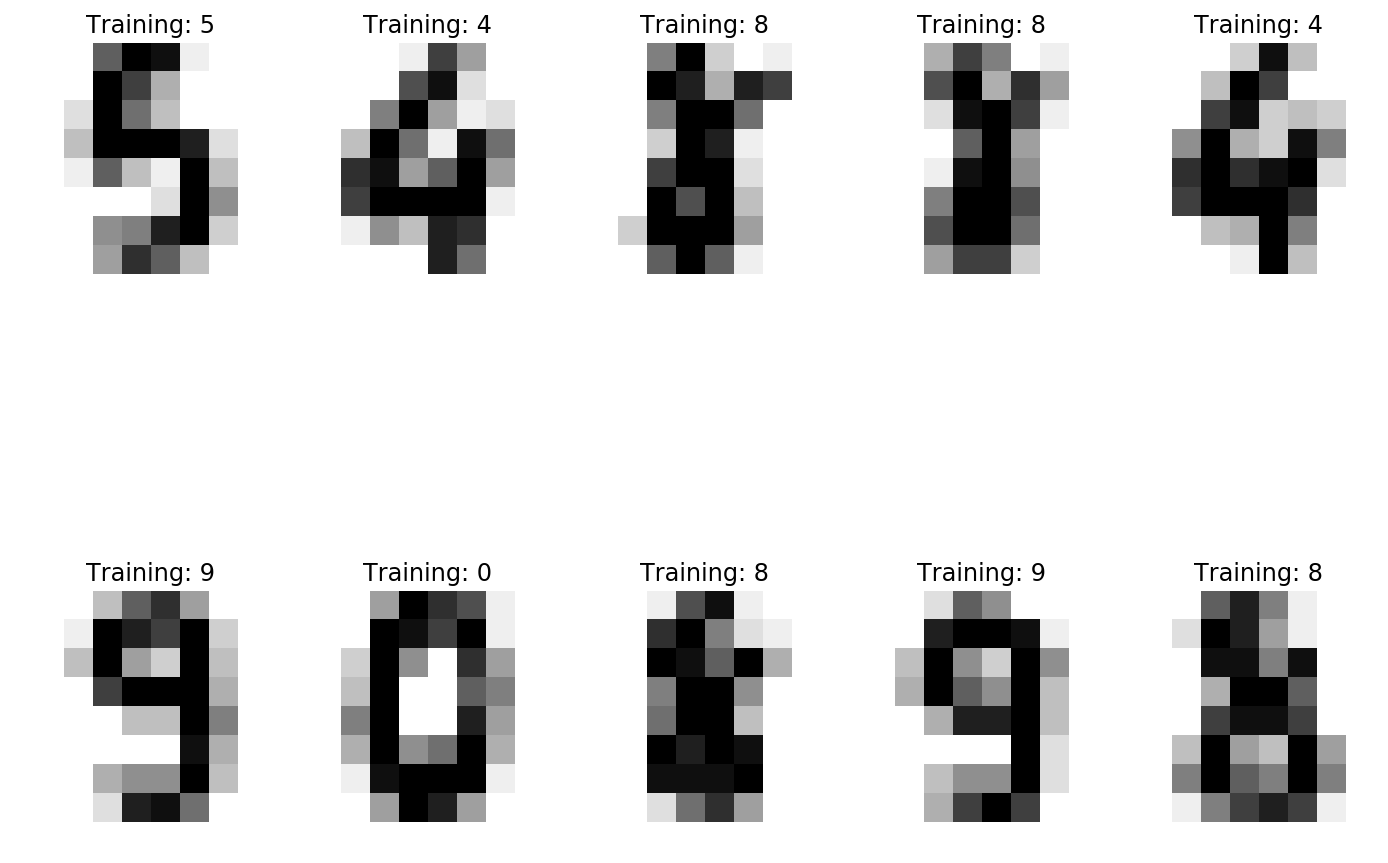

In [8]:
predicted = getArrayFromNT(predictions)
images_and_labels = list(zip(digits.images[-10:], predicted[-10:]))
for index, (image, label) in enumerate(images_and_labels):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

### Compare with scikit-learn SVC
Finally, as a comparison, see a solution below that uses Support Vector Classifier from scikit-learn [`sklearn.svm.svc`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). We get the timings for both training and prediction. We also calculates the average accuracy of predictions. How does the pyDAAL solution compare against this solution?

In [9]:
from sklearn import svm, metrics

sklearn_classifier = svm.SVC(kernel='linear')

%time sklearn_classifier.fit(digits.data[:-100], digits.target[:-100])

%time sklearn_predictions = sklearn_classifier.predict(digits.data[-100:])

sklearn_quality = metrics.accuracy_score(digits.target[-100:], sklearn_predictions)
print('Average accuracy: {:.2f}%'.format(sklearn_quality*100))

Wall time: 88 ms
Wall time: 4 ms
Average accuracy: 98.00%


### Summary
In this lab we learned Support Vector Machine, a powerful classification algorithm. We saw how to use SVM in conjunction with a multi-class classifier to recognize handwritten digits. We also compared the execution time and the prediction quality between a pyDAAL solution and a scikit-learn solution.